In [5]:
from prepare_data import load_and_prepare_data
import pandas as pd

# Чтение из файла
hw_AEP = pd.read_csv("hw_AEP.csv", index_col="Datetime", parse_dates=True)

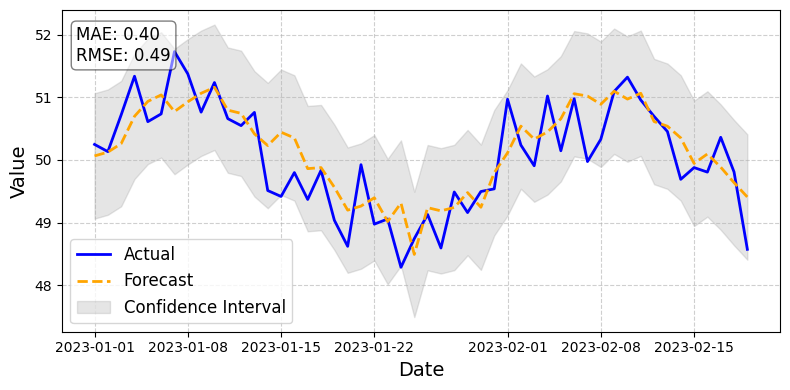

In [ ]:
import numpy as np
from plots import plot_forecast_results

np.random.seed(42)

# Создание временного ряда
dates = pd.date_range(start="2023-01-01", periods=50)
y_true = pd.Series(
    50 + np.sin(np.linspace(0, 10, 50)) + np.random.normal(0, 0.5, 50), index=dates
)
y_pred = pd.Series(
    50 + np.sin(np.linspace(0, 10, 50)) + np.random.normal(0, 0.2, 50), index=dates
)

# Доверительные интервалы
intervals = pd.DataFrame({"lower": y_pred - 1.0, "upper": y_pred + 1.0}, index=dates)

# Вызов функции
plot_forecast_results(y_true, y_pred, intervals, title=None)

In [1]:
import numpy as np
import pandas as pd
from plots import plot_acf_with_intervals

np.random.seed(42)
n_points = 100
dates = pd.date_range(start="2020-01-01", periods=n_points, freq="D")
series = pd.Series(
    10 + np.sin(2 * np.pi * dates.dayofyear / 365) + np.random.normal(0, 0.5, n_points),
    index=dates,
)

plot_acf_with_intervals(
    series, nlags=30, alpha=0.05, width=800, height=300, plot_original_series=True
)

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

def get_sklearn_gb_model(trial, kwargs):
    """
    Создает модель GradientBoostingRegressor из sklearn с параметрами из trial.
    
    Основные отличия от LightGBM:
    - Вместо num_leaves используется max_leaf_nodes
    - Вместо colsample_bytree используется max_features
    - Параметры регуляризации отличаются (используется только alpha)
    - Нет отдельного параметра для метрики (всегда MSE для регрессии)
    
    Параметры:
        trial: Объект optuna.Trial для оптимизации параметров
        kwargs: Дополнительные параметры модели
    """
    import warnings
    warnings.filterwarnings("ignore")
    
    params = {
        # Основные параметры бустинга
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 5e-1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 3, 100),
        
        # Параметры деревьев
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 20, 50),
        
        # Параметры случайности и регуляризации
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "max_features": trial.suggest_float("max_features", 0.5, 1.0),
        "alpha": trial.suggest_float("alpha", 1e-4, 0.9999, log=True),
        
        # Дополнительные параметры
        "random_state": 42,
        "verbose": 0,
    }
    
    # Добавляем дополнительные параметры из kwargs
    params.update(kwargs)
    
    return GradientBoostingRegressor(**params)

In [30]:
# Пример использования с проверкой результатов
from sklearn.datasets import make_regression
from optimize_hyperparameters import optimize_hyperparameters

# Генерируем тестовые данные
X, y = make_regression(n_samples=1000, n_features=20, random_state=42)
X = pd.DataFrame(X)
y = pd.Series(y)

# Запускаем оптимизацию
results = optimize_hyperparameters(
    X, y, get_sklearn_gb_model, model_kwargs={"random_state": 42}, cv_folds=5
)

# Проверяем результаты
print(f"Лучшие параметры: {results['best_params']}")
print(f"Ошибка на тестовой выборке (MSE): {results['test_score']:.4f}")

# Можем использовать лучшую модель
best_model = results["best_model"]
predictions = best_model.predict(X)

[I 2024-12-20 02:38:22,924] A new study created in memory with name: no-name-b30b4975-beef-4f5c-9153-eb17e7dea821
[I 2024-12-20 02:38:23,298] Trial 0 finished with value: 14281.589762290823 and parameters: {'learning_rate': 0.018105158976663864, 'n_estimators': 76, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_leaf_nodes': 40, 'subsample': 0.817708666627973, 'max_features': 0.5867197902324917, 'alpha': 0.06713042040243641}. Best is trial 0 with value: 14281.589762290823.


[I 2024-12-20 02:38:23,538] Trial 1 finished with value: 37667.26452215543 and parameters: {'learning_rate': 0.00015280212872609712, 'n_estimators': 59, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_leaf_nodes': 35, 'subsample': 0.5878465711064355, 'max_features': 0.8803486906777015, 'alpha': 0.0011015804873644812}. Best is trial 0 with value: 14281.589762290823.
[I 2024-12-20 02:38:23,770] Trial 2 finished with value: 31872.45546912751 and parameters: {'learning_rate': 0.005870149198387603, 'n_estimators': 26, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_leaf_nodes': 34, 'subsample': 0.8824743672085291, 'max_features': 0.928972136592138, 'alpha': 0.0228462809140017}. Best is trial 0 with value: 14281.589762290823.
[I 2024-12-20 02:38:23,903] Trial 3 finished with value: 32486.050051261358 and parameters: {'learning_rate': 0.006578880891365147, 'n_estimators': 32, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_leaf_node

Лучшие параметры: {'learning_rate': 0.1876217235486238, 'n_estimators': 89, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_leaf_nodes': 28, 'subsample': 0.5035844802519679, 'max_features': 0.6797494436879655, 'alpha': 0.4253027847900211}
Ошибка на тестовой выборке (MSE): 2273.9630
